In [1]:
from torch.utils.data import DataLoader
import torch

from model.base.geometry import Geometry
from common.evaluation import Evaluator
from common.logger import AverageMeter
from common.logger import Logger
from data import download
from model import chmnet

In [2]:
args = dict({
    'alpha' : [0.05, 0.1], 
    'benchmark':'pfpascal', 
    'bsz':90, 
    'datapath':'../Datasets_CHM', 
    'img_size':240, 
    'ktype':'psi', 
    'load':'p/pas_psi.pt',
    'thres':'img'
    })

In [3]:
# Model initialization
model = chmnet.CHMNet(args['ktype']).cuda()
model.load_state_dict(torch.load(args['load']))
Evaluator.initialize(args['alpha'])
Geometry.initialize(img_size=args['img_size'])

In [4]:
test_ds = download.load_dataset(args['benchmark'], args['datapath'], args['thres'], 'test')
test_dl = DataLoader(test_ds, batch_size=args['bsz'], shuffle=False)

### Run the model 

In [5]:
with torch.no_grad():
  model.eval()
  idx, batch = next(enumerate(test_dl))
  corr_matrix = model(batch['src_img'].cuda(), batch['trg_img'].cuda())
  prd_kps = Geometry.transfer_kps(corr_matrix, batch['src_kps'].cuda(), batch['n_pts'].cuda(), normalized=False)

/home/taesiri/miniconda3/envs/deep39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/taesiri/miniconda3/envs/deep39/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/ate

In [6]:
# eval_result = Evaluator.evaluate(Geometry.unnormalize_kps(prd_kps), batch)  

## Visualize the Output

In [7]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import os

In [8]:
colors = []

for k in range(32):
  colors.append(np.random.rand(3))

In [9]:
def visualize_output(image_index, colors=colors):
  image_url_src = os.path.join(test_dl.dataset.img_path, test_dl.dataset.src_imnames[image_index])
  image_url_tgt = os.path.join(test_dl.dataset.img_path, test_dl.dataset.trg_imnames[image_index])
  src_image = Image.open(image_url_src)
  tgt_image = Image.open(image_url_tgt)
  
  src_points = batch['src_kps'][image_index].squeeze(0).squeeze(0).numpy()
  tgt_points = prd_kps[image_index].squeeze(0).squeeze(0).cpu().numpy()
  
  nkpts = batch['n_pts'].cpu().numpy()[image_index]
  
  src_points_converted  = []
  w, h = src_image.size

  for x,y in zip(src_points[0], src_points[1]):
    src_points_converted.append([int(x*w/args['img_size']),int((y)*h/args['img_size'])])

  src_points_converted = np.asarray(src_points_converted[:nkpts])
  tgt_points_converted  = []

  w, h = tgt_image.size

  for x,y in zip(tgt_points[0], tgt_points[1]):
    tgt_points_converted.append([int(((x+1)/2.0)*w),int(((y+1)/2.0)*h)])

  tgt_points_converted = np.asarray(tgt_points_converted[:nkpts])
  
  # PLOT
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

  ax[0].imshow(src_image)
  ax[0].scatter(src_points_converted[:, 0], src_points_converted[:, 1], c=colors[:nkpts], )
  ax[0].set_title('Source')
  ax[0].set_xticks([])
  ax[0].set_yticks([])

  ax[1].imshow(tgt_image)
  ax[1].scatter(tgt_points_converted[:, 0], tgt_points_converted[:, 1], c=colors[:nkpts])
  ax[1].set_title('Target')
  ax[1].set_xticks([])
  ax[1].set_yticks([])

  fig.tight_layout()
  fig.suptitle('CHM Sample Output', fontsize=16)
  plt.show()

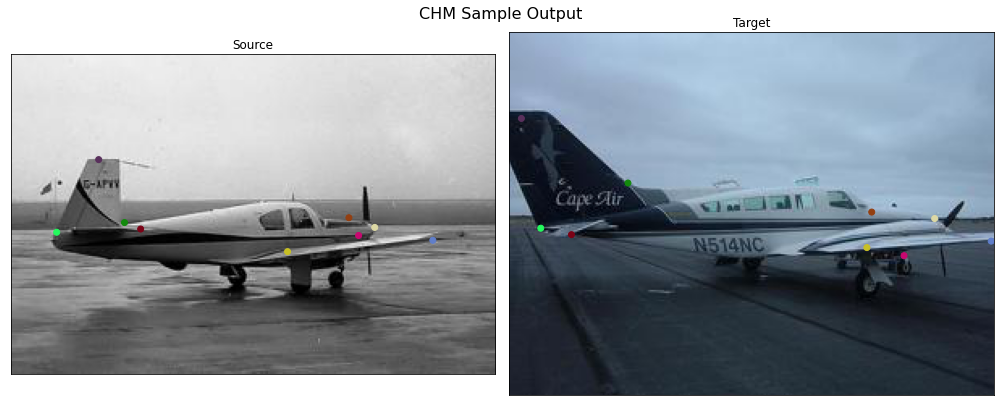

In [10]:
visualize_output(3)

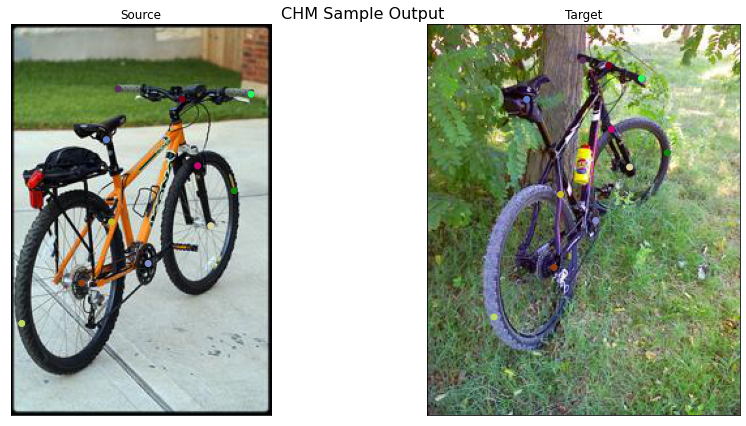

In [11]:
visualize_output(18)

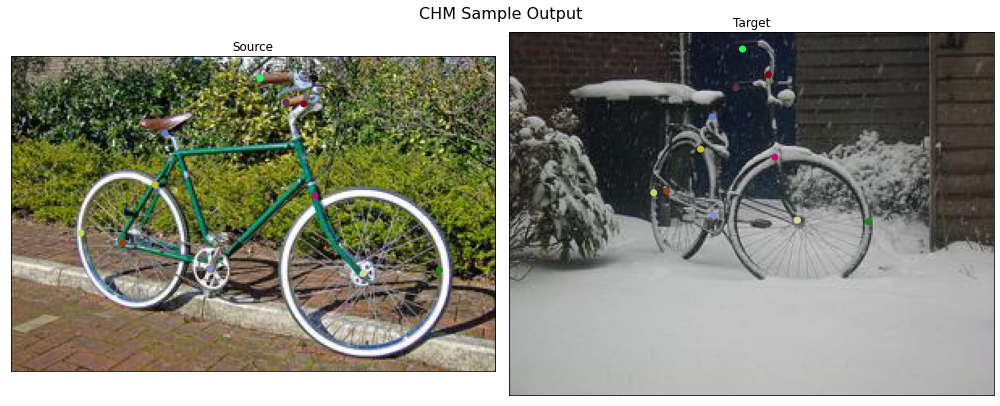

In [12]:
visualize_output(31)

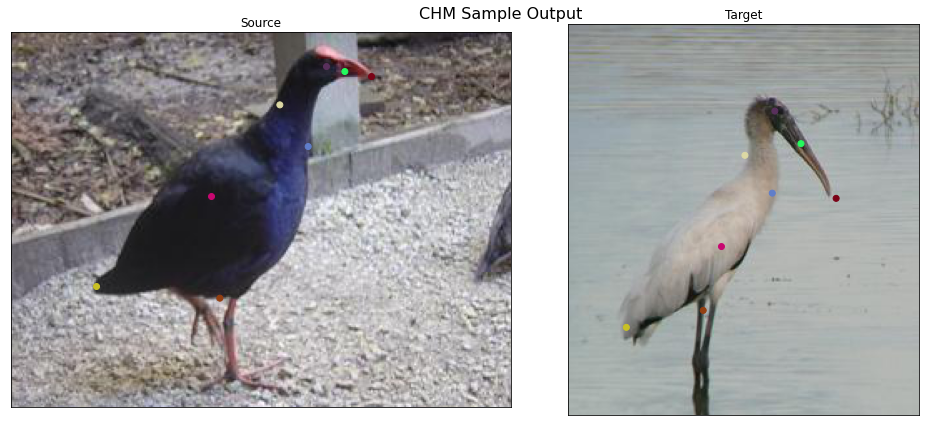

In [13]:
visualize_output(45)

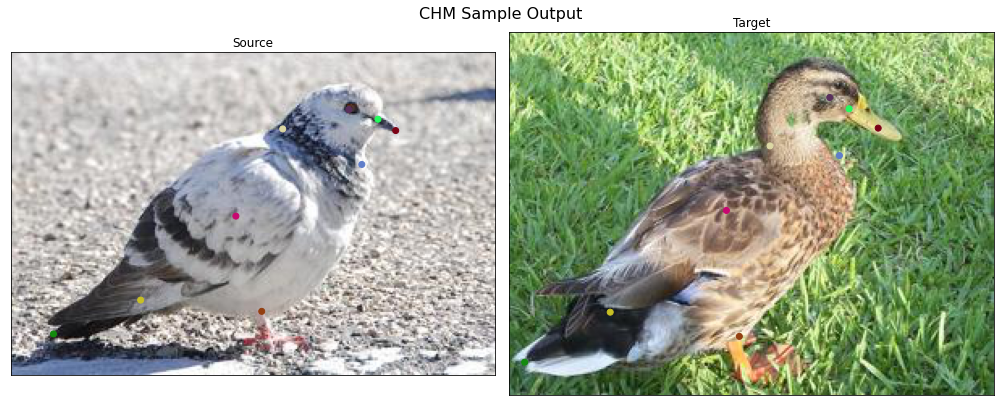

In [14]:
visualize_output(50)

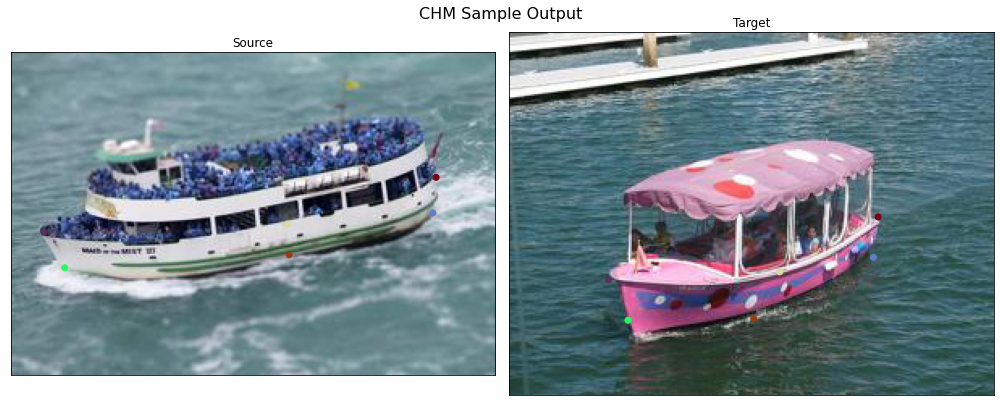

In [15]:
visualize_output(60)

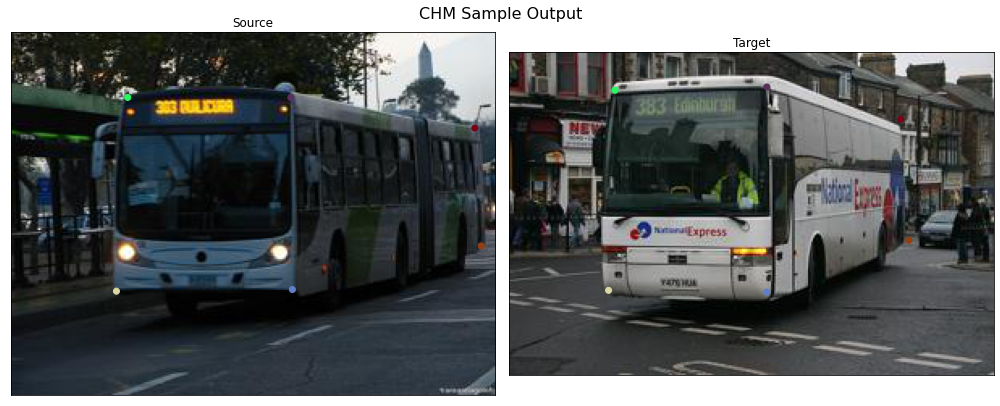

In [16]:
visualize_output(73)